# AIS Pipelines Tutorial

In this workshop you will learn how to design, deploy and run Australian Imaging Service pipelines

##### Preparation
1. Explore the community pipelines repository
1. Start up a test XNAT instance to test the pipelines
1. Set up your Git/GitHub

##### Build and deploy your first pipelines

1. Build *Zip* pipeline from an existing example specification
1. Install, enable and launch the zip pipeline using the XNAT UI
1. Build *FSL BET* pipeline image
1. Install, enable and launch the BET pipeline using `pydra2app ext xnat (install|launch)-command`s

##### Design a pipeline to run mri_convert
1. Create a new Git branch
1. Generate specification for *mri_convert* command
1. Build *mri_convert* pipeline
1. Install project-specific Freesurfer license
1. Test the *mri_convert* pipeline
1. Create a test pull-request on GitHub

##### Design your own pipeline (if you have one in mind)

   Design, build and test your own pipeline using the methods demonstrated in previous sections


## Preparation

### Explore the community pipelines repository

Examine the structure of the pipelines repository using the `tree` utility

In [ ]:
cd ~/git/pipelines-community
tree . --gitignore

Examine the layout of the *Zip* pipelines specification

In [ ]:
cat specs/australian-imaging-service-community/examples/zip.yaml

### Start up a test XNAT instance to test the pipelines

View the public key here so we can use it in subsequent steps while we wait for the test XNAT to start up

In [ ]:
cat $HOME/.ssh/id_rsa.pub

Start a test XNAT on your machine/VM using the `xnat4tests` package

In [ ]:
xnat4tests -c ~/git/pipelines-community/tutorial/xnat4tests-config.yaml start

It will take XNAT a couple of minutes to boot up. Once the frame above completes successfully you will be able to navigate to http://localhost:8080 and login with username=`admin`, password=`admin`.

Now we will add some open-source data from OpenNeuro to our XNAT in order to test the pipelines we will build

In [ ]:
xnat4tests -c ~/git/pipelines-community/tutorial/xnat4tests-config.yaml add-data simple-dir
xnat4tests -c ~/git/pipelines-community/tutorial/xnat4tests-config.yaml add-data openneuro-t1w

### Set up your Git/GitHub

Fork your own copy of the community pipelines repo

1. Navigate to https://github.com
1. Create a GitHub user account (if you don't have one already)
1. Add the SSH key generated in the first step to your GitHub account under `Settings>SSH and GPG keys` (Settings are accessed by clicking your avatar in the top right hand corner)
1. Fork the https://github.com/Australian-Imaging-Service/pipelines-community into your GitHub user account

Set the origin of the repository to your fork

In [ ]:
git remote rename origin upstream
git remote add origin git@github.com:"<your-github-username>"/pipelines-community.git

Update the repository with the latest changes

In [ ]:
git pull upstream

Configure your local Git user

In [ ]:
git config --global user.name "Your Name"
git config --global user.email "youremail@example.com"

Update any dependencies

In [ ]:
pip install --upgrade -r tutorial/requirements.txt

## Build and deploy your first pipelines

### Build *Zip* pipeline from an existing example specification

Checkout the help for the `pydra2app make` command we will use to build the pipeline from the specification

In [ ]:
pydra2app make --help

Run the `pydra2app make` command to build the Zip pipeline from its specification

Notes:

* The name of the built image is taken from its relative file-system path, so we pass the `--spec-root` option to specify where this path should start from
* The `--for-localhost` is required to be able to run the pipeline using the test XNAT repository, i.e. it is only used in development not production
* We export the generated `xnat_command.json` file from the build directory, so we can easily copy it into the XNAT UI in subsequent steps

In [ ]:
pydra2app make xnat \
./specs/australian-imaging-service-community/examples/zip.yaml \
--spec-root ./specs \
--for-localhost \
--export-file xnat_command.json ~/zip-xnat-command.json

**NOTES:**
* `--spec-root` the name and organisation given to the generated image is based on the file path to the specification file, the spec root specifies where this path should be relative to (if not provided it is the current working directory
* `--for-localhost` is required when running the containers on a test XNAT server installed on the localhost
* `--export-file` exports generated files from the build directory to a location they can be accessed more conveniently

We can take a look at the *XNAT command JSON* that is generated by the make process. This is the specification that
tells XNAT how to run the pipeline within the image

In [ ]:
cat ~/zip-xnat-command.json

### Install, enable and launch the zip pipeline using the XNAT UI

##### Install the pipeline
1. Navigate to http://localhost:8080
1. Login with default XNAT credentials: username=`admin` password=`admin`
1. Click on the `Administer` menu item in top ribbon and select `Plugin Settings` from the drop-down menu
1. Select `Images & Commands` under the `Container Service` heading from the left-hand menu
1. Click the `New Command` button and copy and paste the command JSON generated by the build process in the dialog that opens (replacing the `{}` that is already there) and click `Save Command`

##### Enable the pipeline globally
1. Select `Command Configurations` item from the left-hand menu under `Container Service`
1. Toggle the `Enabled` switch next to the Zip pipeline

NB: This enables the pipeline globally, but users still cannot launch the pipeline at this stage. It still needs to be enabled for each project it is to be run on by a project owner.

##### Enable the pipeline for a specific project
1. Navigate back to the home screen by clicking the XNAT logo in the top-left corner
1. Select the `SIMPLE_DIR` project
1. Select `Project Settings` from the bottom of the right-hand actions menu
1. Select `Configure Commands` from the left-hand menu
1. Toggle the `Enabled` switch next to the Zip pipeline

##### Launch the pipeline
1. Navigate back to project home by clicking the `SIMPLE_DIR` breadcrumb
1. Select either one of the two subjects
1. Select the MR session
1. Click on the `Run containers` from the bottom of the right-hand side actions menu and select "Zip up a file or directory"
1. In the `To_zip` field of the dialog that opens up enter `a-directory` to select the scan that is to be zipped and click `Run Container`

##### Check the status of the pipeline
1. In the `History` panel click the `Reload` button and you should see the pipeline status
1. Select the "eye" image that appears to the right of the status when you hover over it to view details of the workflow status
1. If the workflow has failed (after a successful launch), you can view the output and error logs by clicking the `View StdOut.log` and `View StdErr.log` buttons at the bottom of the page.
1. (Advanced) to access the working directory of the command in order to debug anything that has gone wrong, look up the `container-host-path` of the `work` mount listed under `container mounts` (see image below)
1. Select `Manage Files` from the right-hand side Actions menu to view the generated zip file


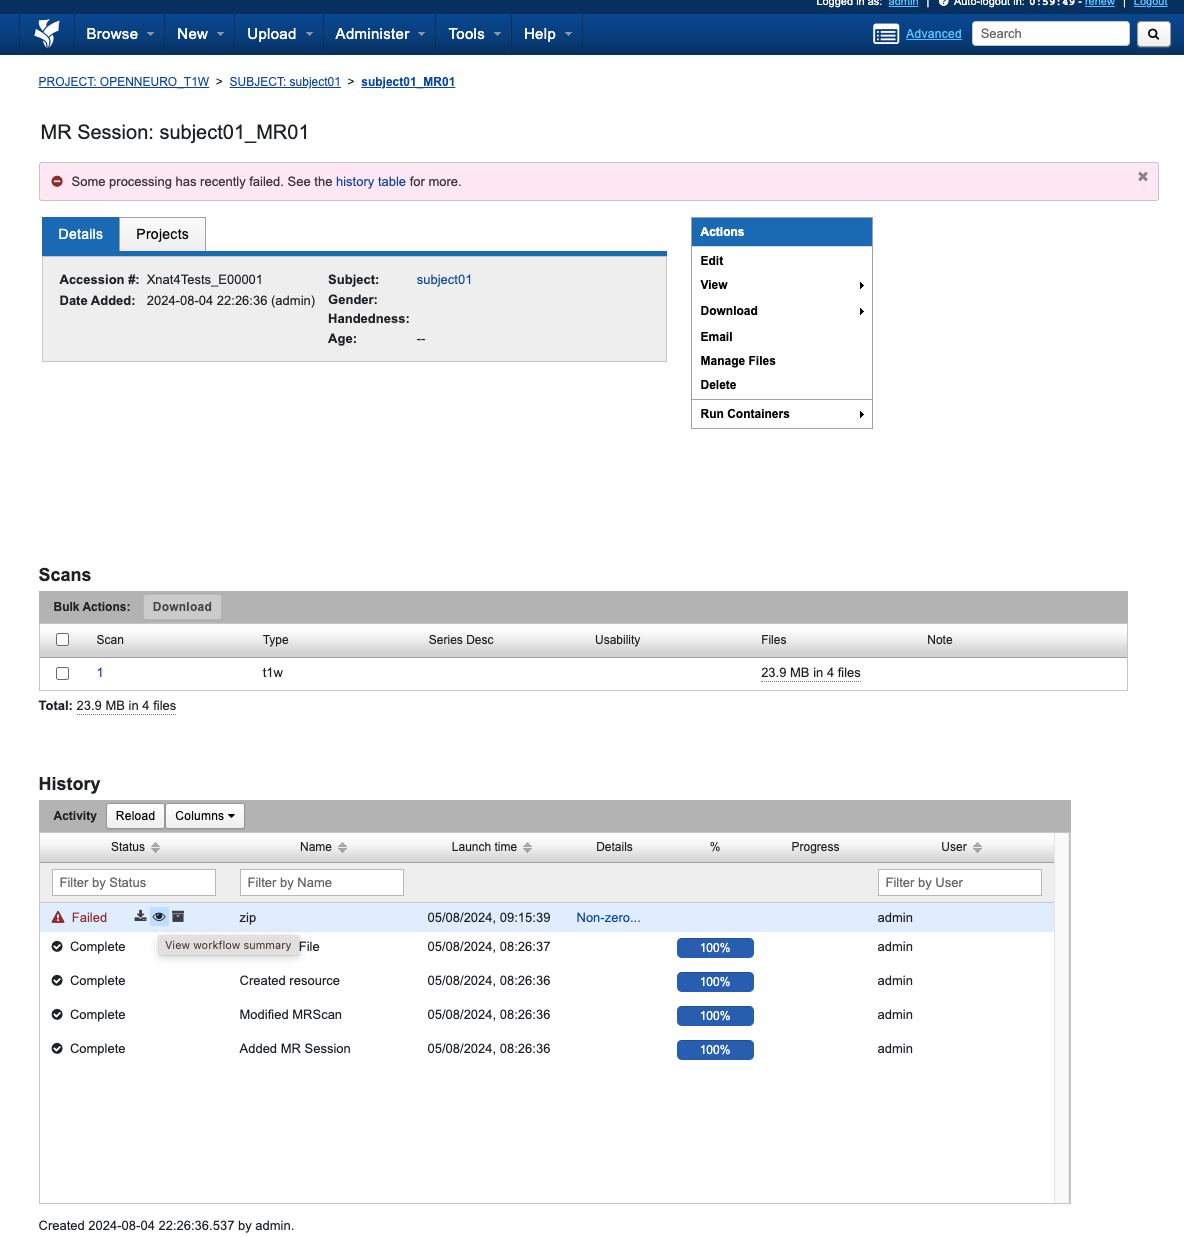




### Build FSL BET pipeline image

Build the example BET specification this time including the licence you just downloaded into the image (as this is permitted by the licence conditions)

In [ ]:
pydra2app make xnat \
./specs/australian-imaging-service-community/examples/bet.yaml \
--spec-root ./specs \
--for-localhost

### Install, enable and launch the BET pipeline using `pydra2app ext xnat (install|launch)-command`s

For convenience (primarily during testing), I have created a couple of commands to install and launch pipelines via the CLI

In [ ]:
pydra2app ext xnat save-token \
--server http://localhost:8080 \
--user admin \
--password admin

In [ ]:
pydra2app ext xnat install-command \
australian-imaging-service-community/examples.bet:6.0.6.4-1 \
--enable \
--enable-project OPENNEURO_T1W \
--replace-existing

In [ ]:
pydra2app ext xnat launch-command \
examples.bet \
OPENNEURO_T1W \
subject01_MR01 \
--input t1w t1w

## Design a pipeline to run mri_convert

### Create a new Git branch

In [ ]:
git checkout -b my-mri-convert

### Generate specification for *mri_convert* command

Using the `pydra2app bootstrap` command we can generate a YAML specification for mri_synthstrip that we can edit later.

<span style="color:orange">**NOTE:**</span> You will need change the `"name-of-your-institution-goes-here"` and `"name-of-your-group-goes-here"` placeholders to appropriate values

In [ ]:
export INSTITUTION_NAME="name-of-your-institution-goes-here"  # e.g. "sydney" for The University of Sydney
export GROUP_NAME="name-of-your-group-goes-here"  # e.g. "sydneyimaging" for Sydney Imaging
export AUTHORS_NAME="Your name goes here"
export AUTHORS_EMAIL="your.email@goes.here"

pydra2app bootstrap \
./specs/australian-image-service-community/au/edu/${INSITUTION_NAME}/${GROUP_NAME}/mri_convert.yaml \
--author ${AUTHORS_NAME} ${AUTHORS_EMAIL} \
--version 7.1.1 \
--base-image vnmd/freesurfer_7.1.1 7.1.1 apt\
--packages-pip fileformats-medimage-extras \
--packages-neurodocker dcm2niix v1.0.20201102 \
--command-task shell \
--command-inputs head "datatype=medimage/nifti-gz,configuration.position=-2,configuration.argstr=''" \
--command-outputs brain "datatype=medimage/nifti-gz,configuration.position=-1,configuration.argstr=''" \
--command-configuration executable mri_convert \
--title "MRI Convert" \
--licenses freesurfer "destination=/opt/freesurfer/license.txt,info_url=https://surfer.nmr.mgh.harvard.edu/registration.html"

You can view the generated YAML specification and make any edits that are required.

In [ ]:
cat ./specs/australian-image-service-community/au/edu/${INSITUTION_NAME}/${GROUP_NAME}/mri_convert.yaml

### Build the `mri_convert` pipeline

Build the newly created pipeline specification

In [ ]:
pydra2app make xnat \
./specs/australian-image-service-community/au/edu/${INSITUTION_NAME}/${GROUP_NAME}/mri_convert.yaml \
--spec-root ./specs \
--for-localhost

### Install a project-specific Freesurfer licence using FrameTree

Download the Freesurfer licence file from Discord or request your own at https://surfer.nmr.mgh.harvard.edu/registration.html

First, create a local reference to the test XNAT server

In [ ]:
frametree store add xnat test-xnat --server http://localhost:8080 --user admin --password admin

Create a default dataset on the Open Neuro T1w project

In [ ]:
frametree dataset define test-xnat//OPENNEURO_T1W

Install the freesurfer license into the OPENNEURO_T1W dataset

In [ ]:
frametree dataset install-license freesurfer ~/freesurfer-license.txt test-xnat//OPENNEURO_T1W

### Test the new pipeline

Install and launch your newly created pipeline

In [ ]:
pydra2app ext xnat install-command \
australian-image-service-community.${INSITUTION_NAME}.${GROUP_NAME}.mri_convert:0.1 \
http://localhost:8080 \
--enable \
--enable-project OPENNEURO_T1W \
--replace-existing

pydra2app ext xnat launch-command \
australian-image-service-community.au.edu.${INSITUTION_NAME}.${GROUP_NAME}.mri_convert:0.1 \
http://localhost:8080 \
OPENNEURO_T1W \
subject01_MR01 \
--input t1w t1w

### Create a test pull-request on GitHub

Commit and your changes

In [ ]:
git commit -am"added specification for Freesurfer's mri_convert"
git push

Create the pull-request on GitHub

1. Navigate to your fork of the AIS community pipelines repo, https://github.com/your-github-username/pipelines-community
1. Select "Pull requests" in the top ribbon
1. Click the "New pull request" button
1. Select "base:main" <- "your-fork:my-mri-convert" from the drop-down lists
1. Click "Create pull request"

This will then start the process for the pipeline to be accepted and deployed

1. Maintainers of AIS Community Pipelines repository (i.e. Arkiev and myself) will be notified that you wish to add your pipeline to the community repository.
1. The repository maintainers (RM) will review your proposed pipeline for security issues
1. RM will potentially request some changes to your specification
1. RM accept your pipeline and merge your pull request
1. The pipeline is built using the continuous integration and deployment actions running on GitHub
1. Checks for newly pipelines are run periodically to pull the latest versions of the pipelines to your local node (although this is not setup at every node yet)

## Design your own pipeline
1. Create and switch to a new Git branch (you will notice that your mri-convert changes will disappear)

In [ ]:
git checkout main
git checkout -b my-own-pipeline

2. Bootstrap your new specification
1. Build your specifcation
1. Test your specification
1. Create a pull-request on GitHub to add your pipeline to the central repository, https://github.com/Australian-Imaging-Service/pipelines-community